# Load packages

In [21]:
import warnings
warnings.filterwarnings('ignore')

In [22]:
import tsai
from tsai.all import *
print('tsai       :', tsai.__version__)
print('fastai     :', fastai.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)

tsai       : 0.2.17
fastai     : 2.3.1
fastcore   : 1.3.19
torch      : 1.8.1+cu111


In [23]:
torch.cuda.get_device_name(0)

'GeForce RTX 2070'

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib import ticker
from datetime import datetime, timedelta
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [25]:
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
           'legend.fontsize': med,
           'figure.figsize': (10, 6),
           'axes.labelsize': med,
           'axes.titlesize': med,
           'xtick.labelsize': med,
           'ytick.labelsize': med,
           'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline

# Version
print(mpl.__version__)
print(sns.__version__)

3.3.2
0.11.0


In [26]:
import hyperopt
print(hyperopt.__version__)
from hyperopt import Trials, STATUS_OK, STATUS_FAIL, tpe, fmin, hp
from hyperopt import space_eval

0.2.5


In [27]:
import time
from fastai.callback.tracker import EarlyStoppingCallback
import gc

In [28]:
import pickle
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_error

# Specify parameters

In [29]:
file_name = "./data/network-traffic-volume-2019-07-01.csv"

history = 15  # input historical time steps, here we use the same value with the maxlag we use for VAR
horizon = 1  # output predicted time steps
test_ratio = 0.2  # testing data ratio

# Load Data

In [30]:
df = pd.read_csv(file_name, sep=';')

In [31]:
start = datetime(1970, 1, 1)  # Unix epoch start time
df['datetime'] = df.clock.apply(lambda x: start + timedelta(seconds=x))

In [32]:
df.head()

,itemid,clock,num,value_min,value_avg,value_max,datetime
0,159138,1563192000,60,170651112,222446310,245355432,2019-07-15 12:00:00
1,159138,1563188400,60,92258968,156333926,245517360,2019-07-15 11:00:00
2,159138,1563184800,60,29854256,73581269,121096792,2019-07-15 10:00:00
3,159138,1563181200,60,333720,12801917,43525128,2019-07-15 09:00:00
4,159138,1563177600,60,183976,1146488,11797152,2019-07-15 08:00:00


Reverse the data order:

In [33]:
df = df.reindex(index=df.index[::-1])
df = df.reset_index(drop=True)

In [34]:
df.head()

,itemid,clock,num,value_min,value_avg,value_max,datetime
0,159138,1547647200,60,176234272,218584709,282860160,2019-01-16 14:00:00
1,159138,1547650800,60,175043128,239018429,302135312,2019-01-16 15:00:00
2,159138,1547654400,60,192060848,247729961,455722696,2019-01-16 16:00:00
3,159138,1547658000,60,185162976,222326142,268226440,2019-01-16 17:00:00
4,159138,1547661600,60,169504880,220546435,306695032,2019-01-16 18:00:00


In [35]:
# add a datetimeindex
dates = pd.DatetimeIndex(df['datetime'])
df = df.set_index(dates).asfreq('H')  # one hour as the original sampling time frequency

In [36]:
df.head()

,itemid,clock,num,value_min,value_avg,value_max,datetime
datetime,,,,,,,
2019-01-16 14:00:00,159138,1547647200,60,176234272,218584709,282860160,2019-01-16 14:00:00
2019-01-16 15:00:00,159138,1547650800,60,175043128,239018429,302135312,2019-01-16 15:00:00
2019-01-16 16:00:00,159138,1547654400,60,192060848,247729961,455722696,2019-01-16 16:00:00
2019-01-16 17:00:00,159138,1547658000,60,185162976,222326142,268226440,2019-01-16 17:00:00
2019-01-16 18:00:00,159138,1547661600,60,169504880,220546435,306695032,2019-01-16 18:00:00


# Split the data

In [37]:
train = df[df['datetime'] < '2019-06-16 00:00:00']
test = df[df['datetime'] > '2019-06-16 00:00:00']
train_length = train.shape[0]
test_length = test.shape[0]

In [38]:
print('Training size: ', train_length)
print('Test size: ', test_length)

Training size:  3610
Test size:  708


In [39]:
print('Test ratio: ', test_length / (test_length + train_length))

Test ratio:  0.16396479851783233


We plot the different time periods data:

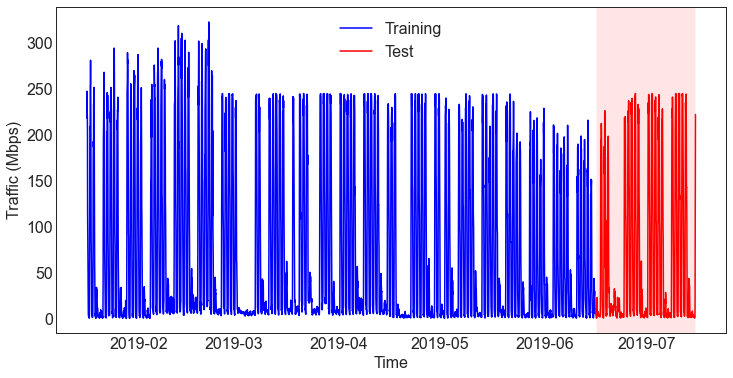

In [40]:
plt.figure(figsize=[12, 6])
plt.plot(df.index[:train_length], df['value_avg'][:train_length] / 1000 / 1000, label='Training', color='blue')
plt.plot(df.index[train_length:], df['value_avg'][train_length:] / 1000 / 1000, label='Test', color='red')
# Not supported for eps
plt.axvspan(df.index[train_length:][0], df.index[train_length:][-1],  facecolor='r', alpha=0.1)

plt.xlabel('Time')
plt.ylabel('Traffic (Mbps)')
plt.legend(loc='best')
# plt.show()
plt.savefig('fig1.pdf', bbox_inches = 'tight', pad_inches = 0.1)

# Plot predicted results

Get the true values on the test set first:

In [45]:
compare_test = test[['value_avg']].copy()
compare_test.columns = ['True Values']

Load the results of VAR:

In [43]:
model_name = 'VAR'
history = 24
horizon = 1
y_pred_fn = '%s_pred-%d-%d.pkl' % (model_name, history, horizon)
var_pred = pickle.load(open(y_pred_fn, 'rb'))

In [46]:
compare_test['VAR'] = var_pred

In [47]:
compare_test.head()

,True Values,VAR
datetime,,
2019-06-16 01:00:00,9214183,9.496324e+06
2019-06-16 02:00:00,4572265,1.533598e+07
2019-06-16 03:00:00,2757564,9.956290e+06
2019-06-16 04:00:00,1749366,8.633895e+06
2019-06-16 05:00:00,937389,5.855331e+06


Define a function to load the results of a single deep learning model:

In [53]:
def load_predicted_results(model_name, history=24, horizon=1, step_to_evalute=0):
    y_pred_fn = '%s_pred-%d-%d.pkl' % (model_name, history, horizon)
    y_pred = pickle.load(open(y_pred_fn, 'rb'))
    return y_pred[:, step_to_evalute]

Load the results of InceptionTime for comparison:

In [54]:
compare_test['InceptionTime'] = load_predicted_results('InceptionTime')

In [55]:
compare_test.head()

,True Values,VAR,InceptionTime
datetime,,,
2019-06-16 01:00:00,9214183,9.496324e+06,3.707059e+06
2019-06-16 02:00:00,4572265,1.533598e+07,4.951978e+06
2019-06-16 03:00:00,2757564,9.956290e+06,3.291661e+06
2019-06-16 04:00:00,1749366,8.633895e+06,2.616202e+06
2019-06-16 05:00:00,937389,5.855331e+06,2.426188e+06


Plot the results for a short time period:

In [61]:
df = compare_test.head(24 * 7)  # the first hours in the test set

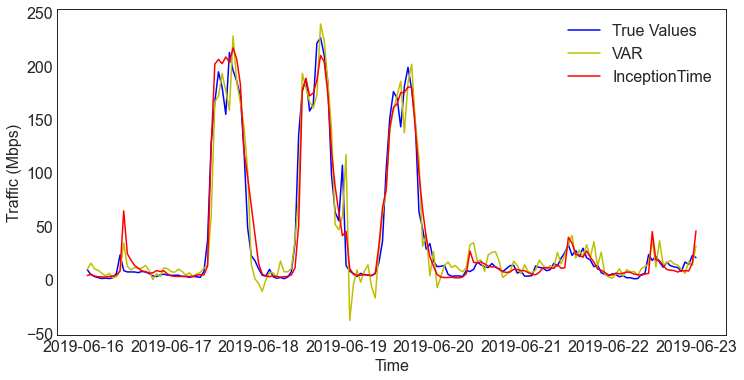

In [64]:
plt.figure(figsize=[12, 6])
plt.plot(df.index, df['True Values'] / 1000 / 1000, 'b', label='True Values')
plt.plot(df.index, df['VAR'] / 1000 / 1000, 'y', label='VAR')
plt.plot(df.index, df['InceptionTime'] / 1000 / 1000, 'r', label='InceptionTime')
plt.xlabel('Time')
plt.ylabel('Traffic (Mbps)')
plt.legend()
# plt.show()
plt.savefig('fig2.pdf', bbox_inches = 'tight', pad_inches = 0.1)